# Simulation functions

In [ ]:
import sys
import os
newPath =  os.path.dirname(os.path.dirname(os.path.abspath("")))
if newPath not in sys.path:
    sys.path.append(newPath)
import BI
import igraph as ig
import matplotlib.pyplot as plt
m = BI.bi(platform='cpu')

c:\Users\SSosa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import sys
newPath = os.path.dirname(os.path.dirname(os.path.abspath("")))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
import igraph as ig
import matplotlib.pyplot as plt
m = bi(platform='cpu')

## Covariates simulation

In [ ]:
import jax.numpy as jnp
import jax.random as jr
jnp.set_printoptions(precision=2,linewidth=200)

def symmetrize(array):
    return (array + array.T) / 2
    
def sim_grp_equal_prob(G, N):
    # Create a 1D array of ones with length G
    ones = jnp.ones((G,))

    # Normalize to get equal probabilities
    equal_probs = ones / G

    # Generate multinomial probabilities
    grp_prob = m.dist.multinomialprobs(equal_probs, 1, sample=True, shape=(N,))

    # Use vmap with jnp.argmax to sample indices
    return vmap(jnp.argmax)(grp_prob)

def sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,3])):
    return [sim_grp_equal_prob(gByGrp[i],N) for i in range(len(gByGrp))]

def create_random_network(n, rate = 0.2, seed=0):
    """
    Create a random network adjacency matrix using the Erdős-Rényi model.
    
    Parameters:
        n (int): Number of nodes in the network.
        rate (float): ate parameter (mean of the distribution), must be >= 0.
        seed (int): Random seed for reproducibility.
        
    Returns:
        jax.numpy.ndarray: Adjacency matrix of the generated random network.
    """
    # Set the random seed for reproducibility
    key = jax.random.PRNGKey(seed)
    
    upper_tri = jax.random.poisson(key,lam = rate,  shape = (n, n))
    lower_tri = upper_tri
    
    # Make the matrix symmetric to represent an undirected graph
    m = upper_tri + lower_tri
    m = m.at[jnp.diag_indices(m.shape[0])].set(0)
    return m

def viz_network(network, block1 = None):
    
    # Convert the input data to NumPy arrays
    adj_matrix_np = np.array(network)
    if block1 is not None:
        block1_np = np.array(block1)
    else:
        block1_np = None


    # Create an igraph graph from the adjacency matrix
    G = ig.Graph.Adjacency((adj_matrix_np > 0).tolist())

    # Add weights to the edges if the adjacency matrix contains weights
    G.es['weight'] = adj_matrix_np[adj_matrix_np.nonzero()] / 4

    # Define the layout
    layout = G.layout_kamada_kawai()
    scale_factor = 20
    layout = [tuple(coord * scale_factor for coord in point) for point in layout]

    # Map the color array to specific colors
    color_map = {0: 'red', 1: 'green', 2: 'blue'}
    if block1_np is not None:
        node_colors = [color_map[block] for block in block1_np]
    else:
        node_colors = ['gray'] * len(G.vs)

    edge_colors = []
    for edge in G.es:
        # 'edge.source' gives the emitter node index for directed graphs.
        edge_colors.append(node_colors[edge.source])
    #G.es["color"] = edge_colors

    # Plot the graph
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ig.plot(G, layout=layout, 
            vertex_size=10, vertex_color=node_colors, 
            edge_width=G.es['weight'], target=ax,
            #edge_color=G.es["color"],
            edge_arrow_size=4, edge_curved = 0.2)

    # Display the plot
    plt.show()

def create_covariates(N=50, times=100,
b_ij_mean1 = 0.5, b_ij_sd1 = 0.5, b_ii_mean1 = 0.7, b_ii_sd1 = 1.5,
b_ij_mean = 0.02, b_ij_sd = 0.1, b_ii_mean = 0.4, b_ii_sd = 0.1,
print_network = False):
    # Network-----------------------------------------------------------
    ## Block ---------------------------------------
    blocks = sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,3]))
    block0=blocks[0]
    block1=blocks[1]
    B0 = bi.net.block_model(block0,1, b_ij_mean = b_ij_mean1, b_ij_sd = b_ij_sd1, b_ii_mean = b_ii_mean1, b_ii_sd = b_ii_sd1,sample=True)
    B1 = bi.net.block_model(block1,3, b_ij_mean = b_ij_mean, b_ij_sd = b_ij_sd, b_ii_mean = b_ii_mean, b_ii_sd = b_ii_sd,sample=True)

    ### SR shape =  N individuals---------------------------------------
    focal_individual_predictors = m.dist.binomial(total_count = 1, logits = 0.5, sample=True, shape=(1,N)) # Fixed covariate
    target_individual_predictors=focal_individual_predictors
    sr =  bi.net.sender_receiver(focal_individual_predictors,target_individual_predictors,
                                 s_mu= -0.5, s_sd= 0.1, r_mu= 0, r_sd= 0.2,
                                 sample=True)

    ## Dyadic shape = N dyads-------------------------------------- 
    covDF = create_random_network(N, rate=0.1) # Fixed dyadic covariate
    covDF = jnp.where(covDF > 0, 1, 0) 
    dyadic_predictors =bi.net.mat_to_edgl(covDF)
    dr = bi.net.dyadic_effect(dyadic_predictors=dyadic_predictors, shape=(N,), sample=True)

    network=bi.net.edgl_to_mat(bi.poisson(jnp.exp(B0 + B1 + sr + dr),sample=True ), N)

    if print_network:
        viz_network(network, block1)

    # Covariates-----------------------------------------------------------
    time = jnp.arange(0,times)
    covF = focal_individual_predictors # Fixed covariate
    jnp.tile(covF[0,:], (times, 1)).T.shape

    # Time-varying covariate

    covV = bi.dist.poisson(5, sample=True, shape=(N,)) # time-varying covariate
    covV = vmap(lambda x: covV + x)(time).T
    covDV = vmap(lambda x: create_random_network(N, rate=0.3, seed=x))(time).transpose(1,2,0) # Time-varying dyadic covariate
    covDF = jnp.stack([covDF] * times, axis=2)

    return {
        'covF': covF[0,:],
        'covV': covV,
        'network': network,
        'covDF': covDF,
        'covDV': covDV
    }

def heatmap(array):
    # Convert to NumPy for Matplotlib
    data_np = jnp.array(array)  # Alternatively, use `data.to_numpy()`

    # Plot heatmap
    plt.imshow(data_np, cmap="viridis", aspect="auto")
    plt.colorbar(label="Value")
    plt.show()


To create covaraites just run ```covariates_data = create_covariates(N=N, times=times)```

## NBDA class
This class will store and adapt data for the NBDA model.

In [ ]:
import pandas as pd
import jax
import jax.numpy as jnp
from jax import vmap

@jax.jit
def scale(x):
    return (x - x.mean()) / x.std()

@staticmethod
@jax.jit
def scale_along_time(covNV):
    return vmap(scale, in_axes = 2, out_axes=2)(covNV)

class NBDA:

    def __init__(self,network,status,names_network=None,names_status=None):
        """
        Initialize an NBDA object with network and status arrays.

        Args:
            network (Array): A 2-dimensional array of shape (n, n) or a 4-dimensional array of shape (n, n, t, num_networks). 
                             If 2D, it is repeated across time. If 4D, it should be created by the user.
            status (Array): A 2-dimensional array of shape (n, t) representing the status of nodes over time.

        Returns:
            None
        """
        # Names of the networks and status
        self.names ={}
        

        # Status 
        self.status=status
        self.n=status.shape[0]
        self.t=status.shape[1]
    
        ## Status at t-1
        self.status_i, self.status_j = self.convert_status(status)
        self.give_name(self.status,'status',names_status)

        # Network
        self.network=None
        if len(network.shape)==2:
            self.convert_network(network)
        elif (len(network.shape)==4):
            self.network=network
        elif (len(network.shape)!=4):
            raise ValueError("Network must be a 2 (n, n) or 4 dimensional array (n, n, t, num_networks)")

        self.give_name(self.network,'network',names_network)

        # Intercepts for the network
        self.intercept = jnp.ones(self.network.shape)

        #self.names_net_status(names_network,names_status)

        # fixed nodal covariates
        self.covNF_i=None
        self.covNF_j=None

        # Time-varying nodal covariates
        self.covNV_i=None
        self.covNV_j=None

        # fixed dyadic covariates
        self.covDF=None

        # Time-varying dyadic covariates
        self.covDV=None

        # individual observed
        self.observed=None

        # Conatenated covariates
        self.D_social=None
        self.D_asocial=None

        # Names

        self.objects = None
    
    def give_name(self, object, key, names):
        if names is  None:
            if object.shape[-1] == 1:
                self.names[key] = f'{key}'
            else:
                self.names[key] = [f'{key}_{i}' for i in range(object.shape[-1])] # last dim is the number of objects
        else:
            if len(names) != object.shape[-1]:
                raise ValueError(f'The number of names ({len(names)}) does not match the number of objects ({object.shape[-1]})')
            else:
                self.names[key] = names
                
    def convert_network(self, network, names = None): # To be used only if there is a single network

        """
        Convert a single network array to a 4D array.

        Args:
            network (Array): A 2-dimensional array of shape (n, n).

        Returns:
            network: A 4-dimensional array of shape (n, n, t, 1) after repeating the network across time.
        """

        self.network=jnp.repeat(network[jnp.newaxis, :, :,jnp.newaxis], self.t, axis=0).transpose((1,2,0,3))

        return self.network

    def convert_status(self, status):#A 2-dimension arrray of (n,t)
        """
        Convert status array to lagged status arrays for i and j.

        Args:
            status (Array): A 2-dimensional array of shape (n, t).

        Returns:
            arrays_status_i (Array): A 3-dimensional array of shape (n, n, t) for i.
            arrays_status_j (Array): A 3-dimensional array of shape (n, n, t) for j.
             ! Both status are the lagged status (t-1) !
        """
        tmp=jnp.concatenate([jnp.zeros((self.n,1)),status[:,:-1]], axis=1)
        tmp2=jnp.array([tmp[:,i][:, None, None]* jnp.ones((self.n, self.n, 1)) for i in range(self.t)])
        tmp3=jnp.array([status[:,i][:, None]* jnp.ones((self.n,  1)) for i in range(self.t)])

        self.arrays_status_i = jnp.transpose(tmp2,(1,2,0,3))
        self.arrays_status_j = jnp.transpose(tmp2,(2,1,0,3))
        self.status = jnp.transpose(tmp3,(1,0,2))
        return self.arrays_status_i, self.arrays_status_j

    def covNF_dims(self,df, n, t, num_variables):
        """
        Convert fixed nodal covariates into 4D arrays.

        Args:
            df (DataFrame or Array): A 2-dimensional array of shape (n, num_variables).
            n (int): Number of nodes.
            t (int): Number of time points.
            num_variables (int): Number of covariates.

        Returns:
            result_array_i (Array): A 4-dimensional array of shape (n, n, t, num_variables) for i.
            result_array_j (Array): A 4-dimensional array of shape (n, n, t, num_variables) for j.
        """
        # Create arrays using broadcasting
        arrays = jnp.array([df[:, var_idx].reshape(-1, 1) * jnp.ones((n, n, t)) for var_idx in range(num_variables)])

        # Transpose arrays to get the required shape
        result_array_j = jnp.transpose(arrays, (1, 2, 3, 0))  # (n, n, t, num_variables)
        result_array_i = jnp.transpose(arrays, (2, 1, 3, 0))  # (n, n, t, num_variables)

        return result_array_i, result_array_j

    def convert_covNF(self, df, n, t, num_variables):
        """
        Convert fixed nodal covariates into 4D arrays.

        Args:
            df (DataFrame or Array): A 2-dimensional array of shape (n, num_variables).
            n (int): Number of nodes.
            t (int): Number of time points.
            num_variables (int): Number of covariates.

        Returns:
            tuple: A tuple of two 4-dimensional arrays (result_array_i, result_array_j).
        """
        if isinstance(df, pd.DataFrame):
            df = jnp.array(df)
        else:
            if len(df)>2:
                raise ValueError("covariates must be a data frame or a 2-dimensional array")

        return  self.covNF_dims(df, n, t, num_variables)

    def import_covNF(self, df, names=None):
        """
        Import fixed nodal covariates.

        Args:
            df (DataFrame or Array): A 2-dimensional array of shape (n, num_variables).

        Returns:
            tuple: A tuple of two 4-dimensional arrays (covNF_i, covNF_j).
        """
        self.covNF_i, self.covNF_j = self.convert_covNF(df, self.n, self.t, df.shape[1])

        self.give_name(self.covNF_i,'covNF',names)

    def convert_covNV(self, covV):
        """
        Convert time-varying nodal covariates into 4D arrays.

        Args:
            covV (Array): A 3-dimensional array of shape (num_variables, n, t).

        Returns:
            tuple: A tuple of two 4-dimensional arrays (result_array_i, result_array_j).
        """
        arrays=jnp.array([covV[i,:, ].T[:, None, :]* jnp.ones((1, self.n, 1)) for i in range(covV.shape[0])])
        result_array_i = jnp.transpose(arrays, (2, 3, 1, 0))  # (n, n, t, num_variables)
        result_array_j = jnp.transpose(result_array_i, (1, 0, 2, 3))
        
        return result_array_i, result_array_j

    def import_covNV(self, covV, names = None, scale = True): #covV need to be a 3 dimensional array of shape (num_var, n, t)i.e. A list of matrices of time-varying covariates
        if scale:
            covV = scale_along_time(covV)
        else: 
            print("Not scaling covariates along time can result in correlation between regressions coefficients in of temporal covariates and the intercepts (i.e. social rate)")
            print("\nAlternative solution would be to add time varying coefficients, but it does affect computational time drastically.")

        self.covNV_i, self.covNV_j = self.convert_covNV(covV)
        self.give_name(self.covNV_i,'covV',names)

    def import_covDF(self, covDF, names = None):
        """
        Import fixed dyadic covariates.

        Args:
            covDF (Array): A 2-dimensional array of shape (n, n) or a 3-dimensional array of shape (n, n, num_dyads).

        Returns:
            Array: A 4-dimensional array of shape (n, n, t, num_variables) if input is 3D, otherwise shape (n, n, t, 1).
        """
        if len(covDF.shape)==2:
            self.covDF = jnp.repeat(covDF[jnp.newaxis, :, :,jnp.newaxis], self.t, axis=0).transpose((1,2,0,3))

        else:
            res = []
            for i in range(covDF.shape[2]):
                res.append(jnp.repeat(covDF[jnp.newaxis,:,:,i], 200, axis=0).transpose((1,2,0)))
            self.covDF = jnp.stack(res, axis = -1)
 
        self.give_name(self.covDF,'covDF',names)

    def import_covDV(self, covDV, names = None):
        """
        Import time-varying dyadic covariates.

        Args:
            covDV (Array): A 3-dimensional array of shape (n, n, t) or a 4-dimensional array of shape (n, n, t, num_dyadics_effects).

        Returns:
            Array: A 4-dimensional array of shape (n, n, t, num_variables).
        """
        
        if len(covDV.shape)==3:# A list of matrices of a single time-varying covariate
            covDV = scale_along_time(covDV)
            self.covDV = covDV[:, :, :,jnp.newaxis]

        if len(covDV.shape)==4:# A ist of list of matrices of a single time-varying covariate
            self.covDV = jnp.array([covDV[i,:, :,None]*jnp.ones((self.n, self.n, self.t)) for i in range(covDF.shape[0])]).transpose((1,2,3,0))
        self.give_name(self.covDV,'covDV',names)

    def stack_cov(self):
        """
        Stack all covariates into a dictionary.

        Returns:
            dict: A dictionary containing all covariates.
        """
        tmp=dict(
            intercept = self.intercept,
            status = self.status,
            status_i = self.status_i, 
            status_j = self.status_j,
            covNF_j = self.covNF_i,
            covNF_i = self.covNF_j,
            covNV_i = self.covNV_i,
            covNV_j = self.covNV_j,
            covDF = self.covDF,
            covDV = self.covDV,
            network = self.network,
            observed = self.observed,
        )
        return {k: v for k, v in tmp.items() if v is not None}

    def get_cov(self):
        """
        Get all covariates in the NBDA object.

        Returns:
            tuple: A tuple of two arrays (D_social, D_asocial).
        """
        
        objects = self.stack_cov()
        self.objects = objects
        D_social = []
        D_asocial = []
        for k in objects.keys():
            if k not in ['status', 'status_i', 'status_j', 'network']:
                if k is not None:   
                    if k in ['intercept', 'covNF_i', 'covNV_i']: 
                        D_social.append(objects[k])
                        D_asocial.append(objects[k][0,:,:,:],)                        
                    else:
                        D_social.append(objects[k])                        
                    

        self.D_social = jnp.concatenate(D_social, axis=-1)
        self.D_asocial = jnp.concatenate(D_asocial, axis=-1)
        return dict(D_social=self.D_social, D_asocial=self.D_asocial, status=self.status, network=self.network)
        
    
    @staticmethod
    def sum_cov_effect(n,t,stacked_betas, stacked_cov):
        """
        Calculate the sum of covariate effects.

        Args:
            n (int): Number of nodes.
            t (int): Number of time points.
            stacked_betas (Array): An array of coefficients.
            stacked_cov (Array): An array of covariates.

        Returns:
            Array: A 3-dimensional array of shape (n, n, t) representing the sum of covariate effects.
        """
        res=jnp.zeros((n,n,t))
        for a in range(len(stacked_cov)):
            res=res.at[:,:,:].set(
            res[:,:,:] +  
            jnp.sum(stacked_cov[a]*stacked_betas[a],axis=3))
    
        return res


    def model(self, social, asocial, cov_social=None, cov_asocial=None):
        D_social=self.D_social
        D_asocial=self.D_asocial
        status=self.status
        network=self.network
        N = status.shape[0]
        T = status.shape[1]
        lk = jnp.zeros((N,T))

        # Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,0,:], asocial, axes=(-1, 0))    
        theta = bi.link.inv_logit(R_asocial)
        lk = lk.at[:,0].set(theta)      
        for t in range(1,T):
            ## Social learning-----------------------
            R_social = jnp.tensordot(D_social[:,:,t,:], social, axes=(-1, 0))
            phi = bi.link.inv_logit(R_social)
            attention_weigthed_network = phi*network[:,:,t,0]
            social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))       
            ## Asocial learning -----------------------
            R_asocial = jnp.tensordot(D_asocial[:,t,:], asocial, axes=(-1, 0))
            theta = bi.link.inv_logit(R_asocial)

            # Informed update at t!= 0-----------------------
            lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))       

        mask = ~jnp.isnan(lk)
        with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
            numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])


    # We can add individual observation information in the same forme as  an input time varying cov
    # We can add multiple behaviors acquisition in the form of a (n,n,t,num_behaviors)
    # Random variable to add
    # Do we add inverse of status_i? As we need net filter by j status that are informed (net*status_j) and cov array filtered by i status that are zero (cov*(1-status_i))


## Diffusion simulations


In [ ]:
import ipdb
@jax.jit
def inv_logit2(x):
    """
    Modified inverse logit function scaling between 0 and 1.
    """
    return (bi.inv_logit(x) - 0.5) * 2


In [ ]:
import random as random2

def diffusion(data, alpha_social, alpha_asocial):
    D_social = data.D_social
    D_asocial = data.D_asocial
    informed = jnp.zeros((data.n,  data.t), dtype=int)

    # Asocial learning only at t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], alpha_asocial, axes=(-1, 0))
    theta = bi.link.inv_logit(R_asocial)

    # Informed update at t = 0-----------------------
    informed = informed.at[:,0].set(
        bi.dist.binomial(
            total_count=jnp.ones(theta.shape[0], dtype=int),
            probs=theta, 
            sample=True, 
            seed=random2.randint(0,10000)
        )
    )

    for t in range(1,data.t):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], alpha_social, axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)        
        attention_weigthed_network = phi*data.network[:,:,t,0]
        tmp = np.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0))
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0)))


        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], alpha_asocial, axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)

        # Informed update at t!= 0-----------------------
        p = theta + (1-theta)*social_influence_weight
        informed =  informed.at[:,t].set(jnp.where(informed[:, t-1] == 1, 1, bi.dist.binomial(total_count=jnp.ones(p.shape[0], dtype=int), probs = p, sample=True, seed = random2.randint(0,10000))))

    return informed


## NBDA Model
This model should adapt to NBDA class stored information.
In order to implement time varying coefficients we need to define a function that takes the $V$ covariates and $T$ time points and returns the coefficients. All coefficents of the model need this structure.

### Model without covariates

In [ ]:
def model(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = bi.dist.normal(0, 4, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = bi.dist.normal(0, 4, shape = (1,), sample=False, name='alpha_asoc')

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = bi.link.inv_logit(R_asocial)
    lk = lk.at[:,0].set(theta)


    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)
        
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

In [ ]:
def model():
    # Priors for social effect covariates
    soc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_asoc')

    nbda.model(soc,asoc)


In [ ]:
import jax.numpy as jnp
from jax import lax, jit
import numpyro

def model2(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_asoc')
    
    # Initial timestep (t=0) - Asocial learning
    R_asocial_0 = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    lk = lk.at[:,0].set(bi.link.inv_logit(R_asocial_0) )
    
    # Define a function for a single timestep computation
    def timestep_fn(t, lk_acc):
        # Social learning
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)  # Using logistic directly if possible
        attention_weigthed_network = phi * network[:,:,t,0]
        social_influence_weight =  inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))
        
        # Asocial learning
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)  # Using logistic directly if possible

        # Update lk for timestep t
        lk_new = lk_acc.at[:,t].set(
            jnp.where(
                status[:, t-1][:,0] == 1, 
                jnp.nan, 
                theta + (1-theta)*social_influence_weight[:,0]
                )
            )
        
        return lk_new
    
    # Use lax.fori_loop for better performance than Python loop
    lk = lax.fori_loop(
        1, T,  # Loop from 1 to T-1
        lambda i, lk_acc: timestep_fn(i, lk_acc),
        lk
    )

    
    # Sample with mask
    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])
    
    return lk

## Plot posterior distribution and simulated data

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random as random2
import math

def generate_random_hex_color():
    number = random2.randint(0, 0xFFFFFF)
    return f"#{number:06X}"

def plot_distributions(posteriors , true_values = dict(alpha_asoc=-5, alpha_soc=1), by_param=False):
    parameters = list(posteriors.keys())
    
    if by_param:
        # Calculate number of rows and columns needed
        n_params = 0
        newParam = []
        for a in parameters:
            if posteriors[a].size > 1:
                n_params += 1
                newParam.append(a)

        parameters = newParam
        
        # Limit columns to between 1 and 3
        if n_params <= 1:
            n_cols = 1
        elif n_params <= 3:
            n_cols = n_params
        else:
            n_cols = 3       

            
        # Calculate number of rows based on n_params and n_cols
        n_rows = math.ceil(n_params / n_cols)
        
        # Create a figure with subplots
        if n_params == 1:
            fig, axes = plt.subplots(1, 1, figsize=(15, 10))
            # Convert single axis to array to make indexing consistent
            axes = np.array([axes])
        else:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
            # Ensure axes is always a 2D array for consistent indexing
            if n_rows == 1:
                axes = axes.reshape(1, -1)
        
        fig.tight_layout()
    else:
        plt.figure(figsize=(10, 6))
    
    legend_handles = []
    
    for param in parameters:
        if by_param:
            # Calculate index for subplot positioning
            idx = parameters.index(param)
            row = idx // n_cols
            col = idx % n_cols
            
            # Access the appropriate subplot
            if n_params == 1:
                ax = axes[0]
            else:
                ax = axes[row, col]
        else:
            ax = plt.gca()

        mean = posteriors[param].mean(axis=0)
        std = posteriors[param].std(axis=0)
        
        if mean.shape == ():
            color = generate_random_hex_color()
            
            # Create a histogram to get the distribution data
            n, bins, patches = plt.hist(posteriors[param], bins=50, density=True, alpha=0.0)
            
            # Add true value offset
            n = n + true_values[param]
            density = n
            
            # Center the distribution
            center_in_density = density.mean()
            density_shifted = density - center_in_density
            
            # Scale the distribution
            scale_factor = 0.3
            density_scaled = density_shifted * scale_factor
            
            # Shift to true value position
            density_final = density_scaled + true_values[param]
            
            # Get bin centers
            bin_centers = (bins[1:] + bins[:-1]) / 2
            
            # Plot the distribution
            if by_param:
                ax.plot(n, bin_centers, color=color)
                ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
            else:
                ax.plot(density_final, bin_centers, color=color)
                ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
            
            # Add legend handle
            legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=f"{param}")
            legend_handles.append(legend_handle)
            
            # Add labels and title
            ax.set_xlabel(f" True Value of Parameter {param}")
            ax.set_ylabel(f" Posterior distribution of Parameter {param}")
            ax.set_title(f'Distribution of {param}')
            if by_param:
                # Set individual y-axis limits for each subplot
                y_min = min(posteriors[param][:, a])
                y_max = max(posteriors[param][:, a])
                padding = 0.1 * (y_max - y_min)
                ax.set_ylim(y_min - padding, y_max + padding)           
            
            if not by_param:
                ax.grid(False)
        else:
            color = generate_random_hex_color()
            length = len(mean)
            
            for a in range(length):
                color = generate_random_hex_color()
                
                # Create a histogram to get the distribution data
                n, bins, patches = plt.hist(posteriors[param][:, a], bins=50, density=True, alpha=0.0)
                
                # Add true value offset
                n = n + true_values[param][a]
                density = n
                
                # Center the distribution
                center_in_density = density.mean()
                density_shifted = density - center_in_density
                
                # Scale the distribution
                scale_factor = 0.3
                density_scaled = density_shifted * scale_factor
                
                # Shift to true value position
                density_final = density_scaled + true_values[param][a]
                
                # Get bin centers
                bin_centers = (bins[1:] + bins[:-1]) / 2
                
                # Plot the distribution
                if by_param:
                    ax.plot(n, bin_centers, color=color)
                    ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
                else:
                    ax.plot(density_final, bin_centers, color=color)
                    ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
                
                # Add legend handle
                legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=f"{param}_{a}")
                legend_handles.append(legend_handle)
                
                # Add labels and title
                ax.set_xlabel(f" True Value of Parameter {param}_{a}")
                ax.set_ylabel(f" Posterior distribution of Parameter {param}_{a}")
                ax.set_title(f'Distribution of {param} ({a})')

                if by_param:
                    # Set individual y-axis limits for each subplot
                    y_min = min(posteriors[param][:, a])
                    y_max = max(posteriors[param][:, a])
                    padding = 0.1 * (y_max - y_min)
                    ax.set_ylim(y_min - padding, y_max + padding)

                if not by_param:
                    ax.grid(False)
    
    if not by_param:
        plt.xlabel(f" True Values ")
        plt.ylabel(f" Posterior distribution")
        plt.grid(False)
        plt.axis('tight')
        plt.legend(handles=legend_handles)
        plt.show()
    else:
        for ax in axes.ravel():
            if not ax.has_data():
                ax.axis('off')
        plt.axis('tight')
        plt.tight_layout()
        plt.show()

# Fro further details on the posterior distributions, we can plot the KDE of each parameter
def kde(array, original_value, name = None, mean = True):
    if mean :
        estimated_mean = array.mean()
    else:
        estimated_mean = jnp.median(array)
    original_value = original_value
    sns.histplot(array, kde=True, bins = 100)
    plt.axvline(original_value, color='r', linestyle='dashed', linewidth=1, label='Simulated value')
    plt.axvline(estimated_mean, color='g', linestyle='dashed', linewidth=1, label='Estimated value')
    plt.xticks([estimated_mean, original_value], 
           [f'{estimated_mean:.2f}', f'{original_value:.2f}'])
    if name is not None:
        plt.title(f'Posterior distribution  vs simulated value for {name}')
    else:
        plt.title(f'Posterior distribution  vs simulated value')
    plt.show()

def params_kde(m, alpha_asocial, alpha_social):
    original_values = [alpha_asocial[0].tolist(), 
                       alpha_social[0].tolist()] + alpha_asocial[1:].tolist() + alpha_social[1:].tolist()
    count = 0
    for k in m.posteriors.keys():
        if m.posteriors[k].shape[1] == 1:
            kde(m.posteriors[k][:,0], original_values[count], name=k)
            plt.close()
            count += 1
        else:
            for i in range(m.posteriors[k].shape[1]):
                kde(m.posteriors[k][:,i], original_values[count], name=k)
                plt.close()
                count += 1



# Running a single simulation 
No covariates, only asocial and social intercept.

In [ ]:
N=50 # Number of individuals
times=50 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'


Simulated network with N =  50


AttributeError: type object 'bi' has no attribute 'net'

In [15]:
m = bi()
m.NBDA(network=covariates_data['network'], status=jnp.zeros((N,times))) 


jax.local_device_count 16


NameError: name 'covariates_data' is not defined

In [11]:
m = bi()
m.nbda(network=covariates_data['network'], status=jnp.zeros((N,times))) 
m.nbda.import_covNF(df=pd.DataFrame(scale(covariates_data['covF'])))
m.nbdaModel

jax.local_device_count 16


TypeError: 'NBDA' object is not callable

In [ ]:
N=100 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=m.nbda(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1])
alpha_asocial =jnp.array([-5])
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

nbda=m.nbda(covariates_data['network'], status) 
nbda.get_cov()

# Run model to recover parameters
m = bi()
#m.data_on_model=nbda.get_cov()
m.run(m.nbda.model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
#plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

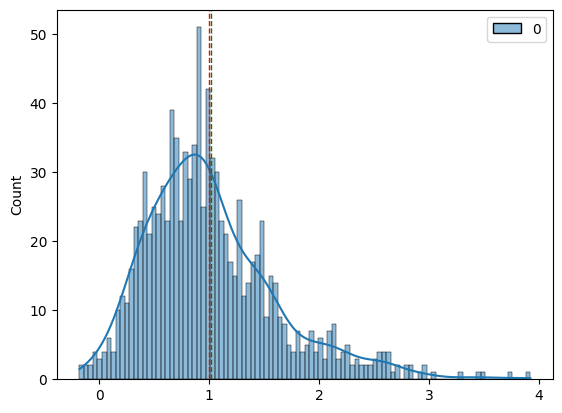

In [13]:
m.posteriors['alpha_soc'].mean()
m.posteriors['alpha_soc'].std()
sns.histplot(m.posteriors['alpha_soc'], kde=True, bins = 100)
plt.axvline(alpha_social, color='r', linestyle='dashed', linewidth=1)
plt.axvline(m.posteriors['alpha_soc'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.show()

# Main simulation function

This function runs the simulation as shown in the previous section and returns:

* The simulated data
* The true parameters
* The estimated parameters

In [19]:
import gc
def main(N = 100, times = 30, alpha_social = jnp.array([-10]), alpha_asocial = jnp.array([-1]),
         print_network= False, print_status = False):
    """Main simulation function

    Args:
        N (int, optional): Number of individuals. Defaults to 100.
        times (int, optional): Number of time steps. Defaults to 30.
        alpha_social (jnp.array, optional): Coefficients for social effect covariates. Defaults to jnp.array([-10]).
        alpha_asocial (jnp.array, optional): Coefficients for asocial effect covariates. Defaults to jnp.array([-1]).
    """

    covariates_data = create_covariates(N=N, times=times, print_network= print_network,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'
    nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
    nbda.get_cov()

    # Set simulation parameters (those to recover)
    status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion
    nbda=NBDA(covariates_data['network'], status) 
    nbda.get_cov()

    if print_status:
        heatmap(nbda.status)

    # Run model to recover parameters
    m = bi()
    #m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
    m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0, progress_bar=False) 
    summary = m.summary(kind = 'all')

    return nbda, summary['mean'].values, m, covariates_data

#main(print_status = True,stop_when_informed = True) #! stop_when_informed not working

# Testing different scenarios
We will run main function to generate X simulations with different paramters

In [15]:
import random as random2
import time
import gc

def sim_estimations(alphas_asocial, alphas_social, 
                    Ns = jax.random.randint( jax.random.PRNGKey(int(time.time())), shape=(1,), minval=50, maxval=200),
                    NTimes = jax.random.randint( jax.random.PRNGKey(int(time.time()+1)), shape=(1,), minval=50, maxval=100),
                    print_network = False, print_status = False):

    # sim -------------------------------
    estimated_alphas_asocial = []
    estimated_alphas_social = []
    nbdas = []
    ms = []

    for i in range(alphas_asocial.shape[0]):
        m = bi()
        print("Estimation for alpha_social = ", alphas_social[i], " and alpha_asocial = ", alphas_asocial[i], " with N = ", Ns[i], " and times = ", NTimes[i])
        nbda, summary, m, covariates_data = main(N = int(Ns[i]), times = int(NTimes[i]), alpha_social = jnp.array([alphas_social[i].item()]), alpha_asocial =  jnp.array([alphas_asocial[i].item()]),
                                                print_network = print_network, print_status = print_status)
        print("Estimated alpha_social = ", summary[1]," / true alpha_social = ", alphas_social[i],  ";  and estimated alpha_asocial = ", summary[0], "/ true alpha_asocial = ",  alphas_asocial[i])
        estimated_alphas_asocial.append(summary[0])
        estimated_alphas_social.append(summary[1])
        nbdas.append(nbda)
        ms.append(m)
        del nbda, summary
        gc.collect()
        print("-------------------------------------------------------------")

    # Plots -------------------------------
    asoc_true = {}
    soc_true = {}
    asoc_estimated = {}
    soc_estimated = {}
    for a in range(alphas_asocial.shape[0]):
        name = str(a)
        asoc_estimated[name] = ms[a].posteriors['alpha_asoc']
        soc_estimated[name] =  ms[a].posteriors['alpha_soc']
        asoc_true[name] = [alphas_asocial[a].item()]
        soc_true[name] = [alphas_social[a].item()]

    plot_distributions(soc_estimated, soc_true, by_param=False)
    plot_distributions(asoc_estimated, asoc_true, by_param=False)
    return estimated_alphas_asocial, estimated_alphas_social, nbdas, ms

## No covariates, fixed null social effect and varying asocial effects

In [ ]:
# ! When asocial effect is to big every individual learn at time step 0 and there is no acquision through time
NSIM = 100
alphas_asocial = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True)
alphas_social = jnp.full(NSIM, -5 )

sim1 = sim_estimations(alphas_asocial = alphas_asocial,
                       alphas_social = alphas_social)

## No covariates, fixed null asocial effect and varying social effects

In [ ]:
# ! When asocial effect is to big every individual learn at time step 0 and there is no acquision through time
NSIM = 100
alphas_social = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True)
alphas_asocial = jnp.full(NSIM, -5 )

sim2 = sim_estimations(alphas_asocial = alphas_asocial,
                       alphas_social = alphas_social)

## No covariates, varying asocial and varying social effects

In [ ]:
# ! When asocial effect is to big every individual learn at time step 0 and there is no acquision through time
NSIM = 100
alphas_social = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 0)
alphas_asocial = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 10)

sim3 = sim_estimations(alphas_asocial = alphas_asocial,
                       alphas_social = alphas_social)

#! both asocial and soical effect reach 4, then diffusion process happens very fast
#! We will make variaton in small range, for social range between 0.1 to 0.8 and for asocial range between 0.1 to 0.5

## With covariates
Due to issues related to long tail posterior distribution for social rate when true social transmission rate is strong, we will fix social and asocial rates to a value that is not too strong but still present and incorporate covariates effects one by one and evaluate there correct estimation.

### Model with covariates
The intercept have its own prior set to 0, 5 as we specify a large prior (invert logit of 5 is 0.993). The covariates have their own priors set to 0, 1 as we consider them as scaled


In [67]:
def model2(D_asocial, D_social, network, status2 = None, status = None):
    if status is None:
        status = status2

    N = status.shape[0] # Number of individuals
    T = status.shape[1] # Number of time steps
    P = status.shape[2] # Number of processes

    lk = jnp.zeros((N,T, P))

    # Priors for social effect covariates
    alpha_soc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_soc')
    betas_soc = bi.dist.normal(0, 1, shape = (D_social.shape[3]-1,), sample=False, name='betas_soc')
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = bi.dist.normal(0, 5,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = bi.dist.normal(0, 1, shape = (D_asocial.shape[2]-1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = bi.link.inv_logit(R_asocial)
    lk = lk.at[:,0, 0].set(theta)

    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t, 0].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)

In [47]:
def model2():
    print(nbda.D_social.shape[3])
    alpha_soc = bi.dist.normal(0, 4, shape = (1,), sample=False, name='alpha_soc')
    betas_soc = bi.dist.normal(0, 1, shape = (2,), sample=False, name='betas_soc')
    print(betas_soc.shape)
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = bi.dist.normal(0, 4,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = bi.dist.normal(0, 1, shape = (1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))

    nbda.model(soc,asoc)


In [ ]:
nbdaObject, means, m, covariates_data = main(N = 100, 
                                             times = 30,
                                             alpha_social = jnp.array([1]), 
                                             alpha_asocial = jnp.array([-5]),
                                             print_network= True, print_status = True)
plot_distributions(m.posteriors,  dict(alpha_asoc=jnp.array([-5]), alpha_soc=jnp.array([1])))

So the main simulation data will always have asocial rate set to -5 (nonexistent) and so social rate set to 1 (0.75).



### Nodal Fixed covariate

In [68]:
import pandas as pd
NSIM = 2
alpha_social = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 0)
betas_social = bi.dist.uniform(-3,3, shape = (NSIM,2), sample = True, seed = 0)
alpha_asocial = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 10)
betas_asocial = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 0)
def sim_estimations2(alpha_social, betas_social, 
                     alpha_asocial, betas_asocial,         
                     print_network= False, print_status = False):
    
    simulated_alphas_asocial = []
    simulated_alphas_social = []
    simulated_betas_asocial = []
    simulated_betas_social = []
    nbdas = []
    ms = []
    for a in range(alpha_asocial.shape[0]):
        m = bi()
        N = jax.random.randint( jax.random.PRNGKey(int(time.time())), shape=(1,), minval=50, maxval=200).item()
        T = jax.random.randint( jax.random.PRNGKey(int(time.time()+1)), shape=(1,), minval=50, maxval=100).item()
        covariates_data = create_covariates(N=N, times=T,
                                            print_network= print_network,
                                            b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                            b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

        # ! Dummy nbda object with no status to initialize data for the diffusion process
        nbda=NBDA(covariates_data['network'], jnp.zeros((N,T))) # Initialyze nbda class with dummy status
        nbda.import_covNF(pd.DataFrame(covariates_data['covF'])) # ! Import nodal fixed covariate data to affect diffusion process
        nbda.get_cov()
        # Set simulation parameters (those to recover)
        alpha_social = jnp.array([alpha_asocial[a], betas_social[a][0], betas_social[a][1]]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
        alpha_asocial =jnp.array([alpha_asocial[a], betas_asocial[a]]) #! covNF will have an effect of -5 (i.e. noneexistent)
        status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

        print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
        if print_status:
            heatmap(status)

        #! update nbda object with diffusion process simulated 
        nbda=NBDA(covariates_data['network'], status) 
        nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
        nbda.get_cov()

        # Run model to recover parameters
        m = bi()
        m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
        m.run(model2, num_samples=1000, num_warmup=1000, num_chains=1, seed=0, progress_bar=False) 

        simulated_alphas_asocial.append(alpha_social[a])
        simulated_alphas_social.append(alpha_asocial[a])
        simulated_betas_asocial.append(betas_asocial[a])
        simulated_betas_social.append(betas_asocial[a])
        nbdas.append(nbda)
        ms.append(m)
        del nbda, m
        gc.collect()

    return simulated_alphas_asocial, simulated_alphas_social, simulated_betas_asocial, simulated_betas_social, nbdas, ms

resNF = sim_estimations2(alpha_social, betas_social, alpha_asocial, betas_asocial)   

jax.local_device_count 16
Simulated diffusion  with rows representing individuals  195  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 16
jax.local_device_count 16
Simulated diffusion  with rows representing individuals  102  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 16


In [70]:
resNF

([Array(-2.46, dtype=float64), Array(2.79, dtype=float64)],
 [Array(-2.46, dtype=float64), Array(-1.7, dtype=float64)],
 [Array(-0.49, dtype=float64), Array(-1.7, dtype=float64)],
 [Array(-0.49, dtype=float64), Array(-1.7, dtype=float64)],
 [<__main__.NBDA at 0x27f1eec5790>, <__main__.NBDA at 0x27eaddf3a70>],
 [<main.bi at 0x27fb9d78c50>, <main.bi at 0x27ec2e3f560>])

In [69]:
resNF[5][0].posteriors['betas_soc'].mean(axis=0)

Array([-0.42, -1.16], dtype=float64)

### Nodal time varying covariate
#### Scaling the covariate within each time steps

In [ ]:
import pandas as pd
NSIM = 100
alpha_social = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 0)
betas_social = bi.dist.uniform(-3,3, shape = (NSIM,4), sample = True, seed = 0)
alpha_asocial = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 10)
betas_asocial = bi.dist.uniform(-3,3, shape = (NSIM,2), sample = True, seed = 0)
def sim_estimations3(alpha_social, betas_social, 
                     alpha_asocial, betas_asocial,         
                     print_network= False, print_status = False):
    
    simulated_alphas_asocial = []
    simulated_alphas_social = []
    simulated_betas_asocial = []
    simulated_betas_social = []
    nbdas = []
    ms = []
    for a in range(alpha_asocial.shape[0]):
        m = bi()
        N = jax.random.randint( jax.random.PRNGKey(int(time.time())), shape=(1,), minval=50, maxval=200).item()
        T = jax.random.randint( jax.random.PRNGKey(int(time.time()+1)), shape=(1,), minval=50, maxval=100).item()
        covariates_data = create_covariates(N=N, times=T,
                                            print_network= print_network,
                                            b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                            b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

        # ! Dummy nbda object with no status to initialize data for the diffusion process
        nbda=NBDA(covariates_data['network'], jnp.zeros((N,T))) # Initialyze nbda class with dummy status
        nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
        nbda.import_covNV(covariates_data['covV'][:,:T].reshape((-1,N,T))) # ! Import nodal time-varying covariate data to affect diffusion process
        nbda.get_cov()
        
        # Set simulation parameters (those to recover)
        alpha_social = jnp.array([alpha_asocial[a], betas_social[a][0], betas_social[a][1], betas_social[a][2], betas_social[a][3]]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
        alpha_asocial =jnp.array([alphas_asocial[a], betas_asocial[a][0], betas_asocial[a][1]]) #! covNF will have an effect of -5 (i.e. noneexistent)
        status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion
        
        print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
        #heatmap(status)
        
        #! update nbda object with diffusion process simulated 
        nbda=NBDA(covariates_data['network'], status) 
        nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
        nbda.import_covNV(covariates_data['covV'][:,:T].reshape((-1,N,T))) # ! Import nodal time-varying covariate data to affect diffusion process
        nbda.get_cov()


        # Run model to recover parameters
        m = bi()
        m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
        m.run(model2, num_samples=1000, num_warmup=1000, num_chains=1, seed=0, progress_bar=False) 

        simulated_alphas_asocial.append(alpha_social[a])
        simulated_alphas_social.append(alpha_asocial[a])
        simulated_betas_asocial.append(betas_asocial[a])
        simulated_betas_social.append(betas_asocial[a])
        nbdas.append(nbda)
        ms.append(m)
        del nbda, m
        gc.collect()

    return simulated_alphas_asocial, simulated_alphas_social, simulated_betas_asocial, simulated_betas_social, nbdas, ms

resNV = sim_estimations3(alpha_social, betas_social, alpha_asocial, betas_asocial)   

jax.local_device_count 32
Simulated diffusion  with rows representing individuals  165  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:06<00:00, 15.83it/s, 7 steps of size 4.00e-01. acc. prob=0.89] 


jax.local_device_count 32
Simulated diffusion  with rows representing individuals  82  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:23<00:00, 23.91it/s, 15 steps of size 1.95e-01. acc. prob=0.95]


In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0 ]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
alpha_asocial =jnp.array([-5, -5, -5]) #! covNF will have an effect of -5 (i.e. noneexistent)
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0, progress_bar=False) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


#### QQ-plot

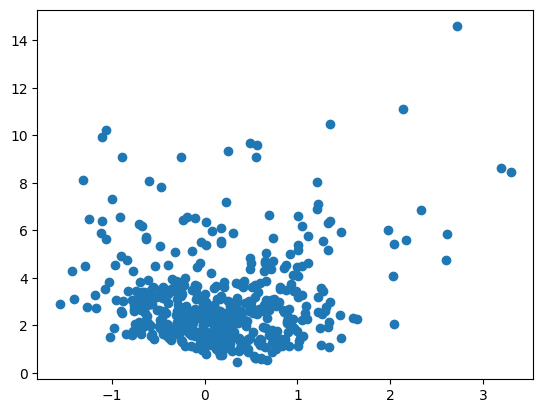

In [ ]:
plt.scatter(m.posteriors['betas_soc'][:,4], m.posteriors['alpha_soc'])

alpha_asoc


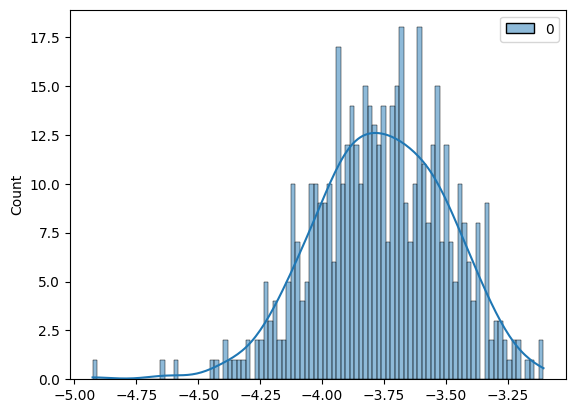

alpha_soc


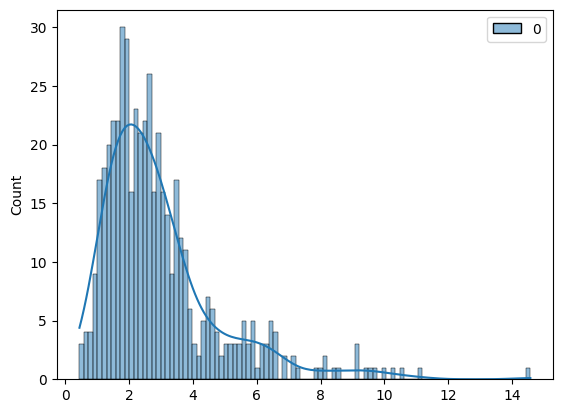

betas_asoc


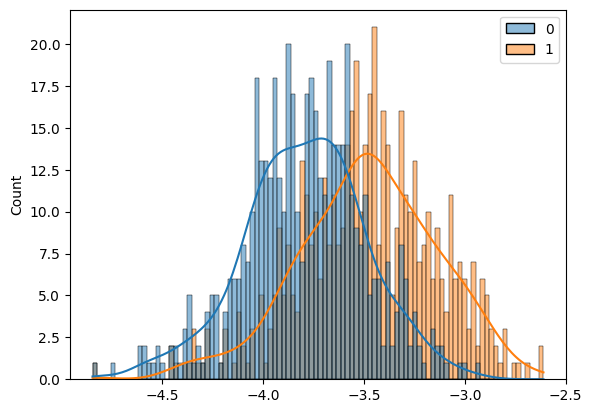

betas_soc


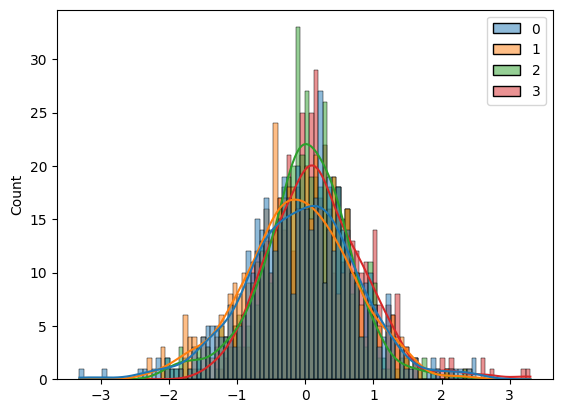

In [ ]:
for k in m.posteriors.keys():
    print(k)
    sns.histplot(m.posteriors[k], kde=True, bins = 100)
    plt.show()
    plt.close()

/tmp/ipykernel_218917/624485197.py:3: UserWarning: Sample's batch dimension size 500 is different from the provided 1000 num_samples argument. Defaulting to 500.
  predictive = Predictive(model, m.posteriors, num_samples=1000)


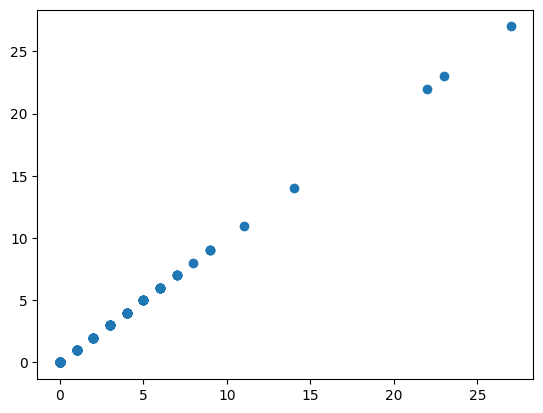

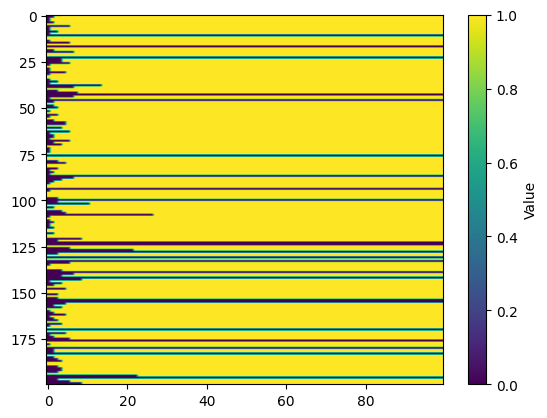

In [ ]:
from numpyro.infer import Predictive
def predict(model, m, nbdaObject):
    predictive = Predictive(model, m.posteriors, num_samples=1000)
    rng_key = jax.random.PRNGKey(1)
    preds = predictive(rng_key, D_asocial = nbdaObject.D_asocial, D_social = nbdaObject.D_social, network = nbdaObject.network, status2 = nbdaObject.status)

    meanPred = jnp.mean(preds['y'][:,:,:,0], axis=0)
    plt.scatter(jnp.argmax(nbdaObject.status, axis=1)[:,0],
            jnp.argmax(meanPred, axis=1))
    plt.show()
    heatmap(meanPred)
    return preds
preds = predict(model, m, nbda)

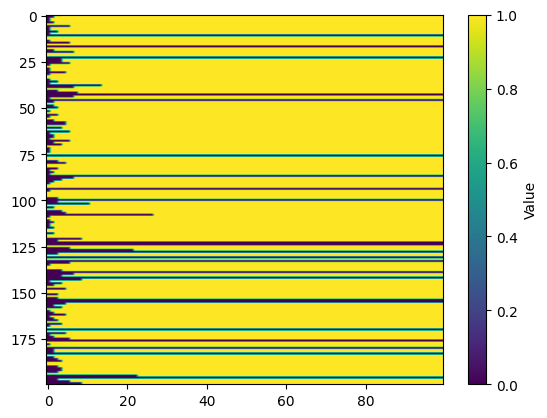

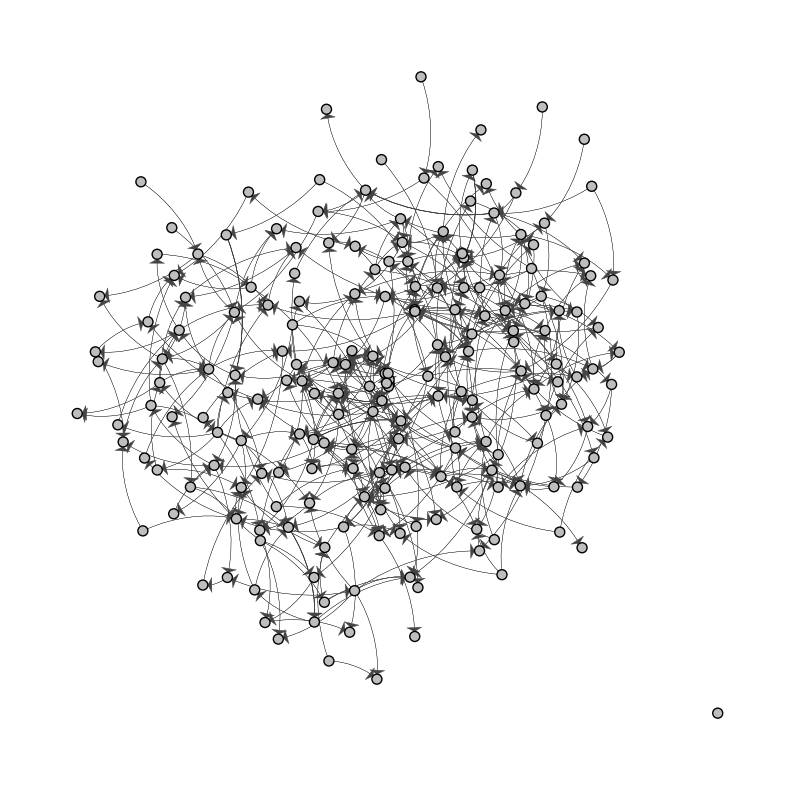

In [ ]:
heatmap(nbda.status)
viz_network(nbda.network[:,:,0,0], )

### Dyadic fixed covariate

In [ ]:
import pandas as pd
NSIM = 100
alpha_social = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 0)
betas_social = bi.dist.uniform(-3,3, shape = (NSIM,5), sample = True, seed = 0)
alpha_asocial = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 10)
betas_asocial = bi.dist.uniform(-3,3, shape = (NSIM,2), sample = True, seed = 0)
def sim_estimations4(alpha_social, betas_social, 
                     alpha_asocial, betas_asocial,         
                     print_network= False, print_status = False):
    
    simulated_alphas_asocial = []
    simulated_alphas_social = []
    simulated_betas_asocial = []
    simulated_betas_social = []
    nbdas = []
    ms = []
    for a in range(alpha_asocial.shape[0]):
        m = bi()
        N = jax.random.randint( jax.random.PRNGKey(int(time.time())), shape=(1,), minval=50, maxval=200).item()
        T = jax.random.randint( jax.random.PRNGKey(int(time.time()+1)), shape=(1,), minval=50, maxval=100).item()
        covariates_data = create_covariates(N=N, times=T,
                                            print_network= print_network,
                                            b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                            b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

        # ! Dummy nbda object with no status to initialize data for the diffusion process
        nbda=NBDA(covariates_data['network'], jnp.zeros((N,T))) # Initialyze nbda class with dummy status
        nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
        nbda.import_covNV(covariates_data['covV'][:,:T].reshape((-1,N,T))) # ! Import nodal time-varying covariate data to affect diffusion process
        nbda.import_covDF(covariates_data['covDF'][:,:,0]) # ! Import dyadic fixed covariate data to affect diffusion process
        nbda.get_cov()

        # Set simulation parameters (those to recover)
        alpha_social = jnp.array([alpha_asocial[a], betas_social[a][0], betas_social[a][1], betas_social[a][2], betas_social[a][3], betas_social[a][4]]) #! Dyadic covariates already have i and j, so a single coefficient
        alpha_asocial = jnp.array([alphas_asocial[a], betas_asocial[a][0], betas_asocial[a][1]]) #! No dyadic covariates for asocial learning
        status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

        print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
        #heatmap(status)

        #! update nbda object with diffusion process simulated 
        nbda=NBDA(covariates_data['network'], status) 
        nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
        nbda.import_covNV(covariates_data['covV'][:,:T].reshape((-1,N,T))) 
        nbda.import_covDF(covariates_data['covDF'][:,:,0])
        nbda.get_cov()

        # Run model to recover parameters
        m = bi()
        m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
        m.run(model2, num_samples=1000, num_warmup=1000, num_chains=1, seed=0, progress_bar=False) 

        simulated_alphas_asocial.append(alpha_social[a])
        simulated_alphas_social.append(alpha_asocial[a])
        simulated_betas_asocial.append(betas_asocial[a])
        simulated_betas_social.append(betas_asocial[a])
        nbdas.append(nbda)
        ms.append(m)
        del nbda, m
        gc.collect()

    return simulated_alphas_asocial, simulated_alphas_social, simulated_betas_asocial, simulated_betas_social, nbdas, ms

resDF = sim_estimations4(alpha_social, betas_social, alpha_asocial, betas_asocial)   

jax.local_device_count 32
Simulated diffusion  with rows representing individuals  77  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:10<00:00, 28.32it/s, 15 steps of size 2.33e-01. acc. prob=0.86]


jax.local_device_count 32
Simulated diffusion  with rows representing individuals  55  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:45<00:00, 43.92it/s, 15 steps of size 2.98e-01. acc. prob=0.93]


Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s, 7 steps of size 2.96e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -4.13  0.29     -4.57      -3.66       0.02     0.01    325.14   
alpha_soc[0]   1.21  0.63      0.28       1.98       0.05     0.04    167.70   
betas_asoc[0] -3.70  0.30     -4.13      -3.19       0.02     0.01    321.17   
betas_asoc[1] -3.40  0.34     -3.97      -2.88       0.02     0.01    290.30   
betas_soc[0]  -0.46  0.55     -1.29       0.36       0.03     0.03    312.92   
betas_soc[1]   0.25  0.40     -0.39       0.83       0.03     0.02    272.93   
betas_soc[2]   0.04  0.41     -0.58       0.67       0.02     0.02    345.22   
betas_soc[3]   0.37  0.40     -0.21       0.89       0.02     0.02    427.31   
betas_soc[4]   0.60  0.76     -0.59       1.79       0.04     0.03    356.88   

               ess_tail  r_hat  
alpha_asoc[0]    470.50    NaN  
alpha_soc[0]     194.42    NaN  
betas_asoc[0]    384.65    NaN  
betas_asoc[1]    406.36    NaN  
betas_soc[0] 

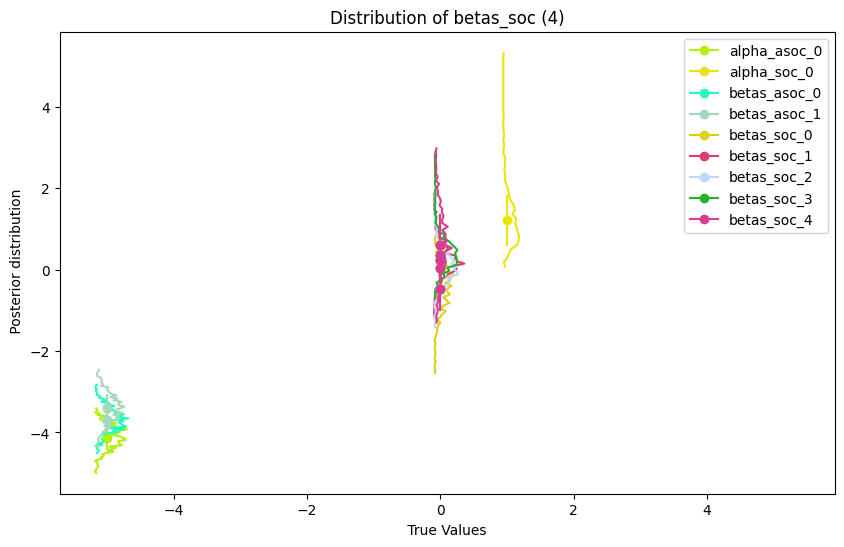

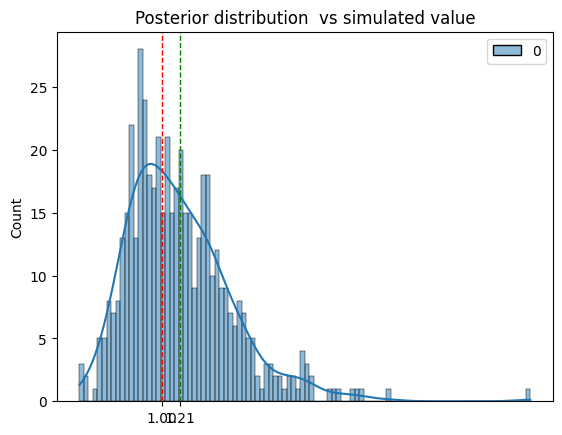

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.import_covDF(covariates_data['covDF'][:,:,0]) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0, 0]) #! Dyadic covariates already have i and j, so a single coefficient
alpha_asocial =jnp.array([-5, -5, -5]) #! No dyadic covariates for asocial learning
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) 
nbda.import_covDF(covariates_data['covDF'][:,:,0])
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


### Dyadic time-varying covariates

In [ ]:
import pandas as pd
NSIM = 2
alpha_social = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 0)
betas_social = bi.dist.uniform(-3,3, shape = (NSIM,5), sample = True, seed = 0)
alpha_asocial = bi.dist.uniform(-3,3, shape = (NSIM,), sample = True, seed = 10)
betas_asocial = bi.dist.uniform(-3,3, shape = (NSIM,2), sample = True, seed = 0)
def sim_estimations5(alpha_social, betas_social, 
                     alpha_asocial, betas_asocial,         
                     print_network= False, print_status = False):
    
    simulated_alphas_asocial = []
    simulated_alphas_social = []
    simulated_betas_asocial = []
    simulated_betas_social = []
    nbdas = []
    ms = []
    for a in range(alpha_asocial.shape[0]):
        m = bi()
        N = jax.random.randint( jax.random.PRNGKey(int(time.time())), shape=(1,), minval=50, maxval=200).item()
        T = jax.random.randint( jax.random.PRNGKey(int(time.time()+1)), shape=(1,), minval=50, maxval=100).item()
        covariates_data = create_covariates(N=N, times=T,
                                            print_network= print_network,
                                            b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                            b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

        # ! Dummy nbda object with no status to initialize data for the diffusion process
        nbda=NBDA(covariates_data['network'], jnp.zeros((N,T))) # Initialyze nbda class with dummy status
        nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
        nbda.import_covNV(covariates_data['covV'][:,:T].reshape((-1,N,T))) # ! Import nodal time-varying covariate data to affect diffusion process
        nbda.import_covDF(covariates_data['covDF'][:,:,0]) # ! Import dyadic fixed covariate data to affect diffusion process
        nbda.import_covDV(covariates_data['covDV']) # ! Import dyadic fixed covariate data to affect diffusion process
        nbda.get_cov()

        # Set simulation parameters (those to recover)
        alpha_social = jnp.array([alpha_asocial[a], betas_social[a][0], betas_social[a][1], betas_social[a][2], betas_social[a][3], betas_social[a][4], betas_social[a][5]]) 
        alpha_asocial =jnp.array([alphas_asocial[a], betas_asocial[a][0], betas_asocial[a][1]])  #! No dyadic covariates for asocial learning
        status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

        print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
        #heatmap(status)

        #! update nbda object with diffusion process simulated 
        nbda=NBDA(covariates_data['network'], status) 
        nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
        nbda.import_covNV(covariates_data['covV'][:,:T].reshape((-1,N,T))) 
        nbda.import_covDF(covariates_data['covDF'][:,:,0])
        nbda.import_covDV(covariates_data['covDV'])
        nbda.get_cov()

        # Run model to recover parameters
        m = bi()
        m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
        m.run(model2, num_samples=1000, num_warmup=1000, num_chains=1, seed=0, progress_bar=False) 

        simulated_alphas_asocial.append(alpha_social[a])
        simulated_alphas_social.append(alpha_asocial[a])
        simulated_betas_asocial.append(betas_asocial[a])
        simulated_betas_social.append(betas_asocial[a])
        nbdas.append(nbda)
        ms.append(m)
        del nbda, m
        gc.collect()

    return simulated_alphas_asocial, simulated_alphas_social, simulated_betas_asocial, simulated_betas_social, nbdas, ms

resDV = sim_estimations5(alpha_social, betas_social, alpha_asocial, betas_asocial)   

jax.local_device_count 32
150
Simulated diffusion  with rows representing individuals  150  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [05:19<00:00,  6.26it/s, 7 steps of size 3.43e-01. acc. prob=0.92] 


jax.local_device_count 32
154
Simulated diffusion  with rows representing individuals  154  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


warmup:  16%|█▌        | 323/2000 [02:29<12:55,  2.16it/s, 15 steps of size 4.14e-01. acc. prob=0.78] 


KeyboardInterrupt: 

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.import_covDF(covariates_data['covDF'][:,:,0]) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.import_covDV(covariates_data['covDV']) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0, 0, 0]) 
alpha_asocial =jnp.array([-5, -5, -5]) #! No dyadic covariates for asocial learning
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) 
nbda.import_covDF(covariates_data['covDF'][:,:,0])
nbda.import_covDV(covariates_data['covDV'])
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


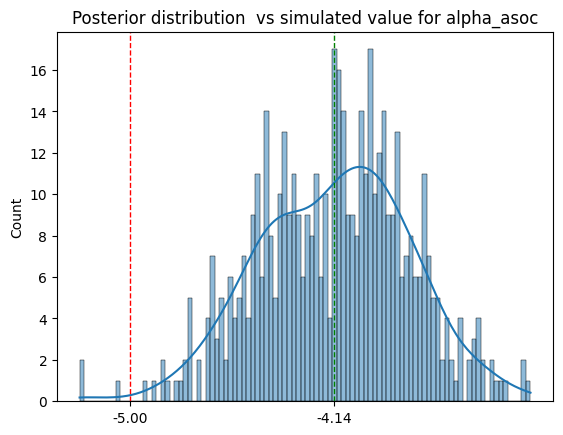

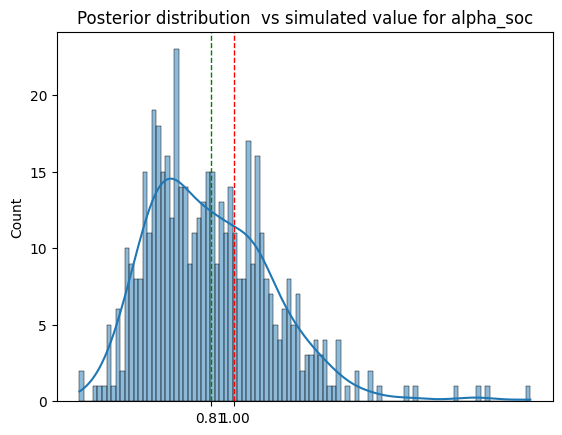

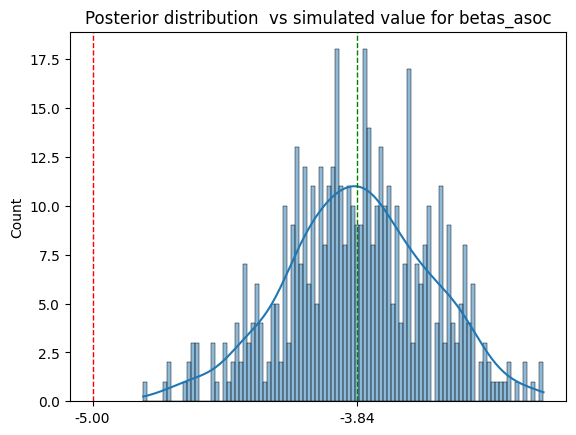

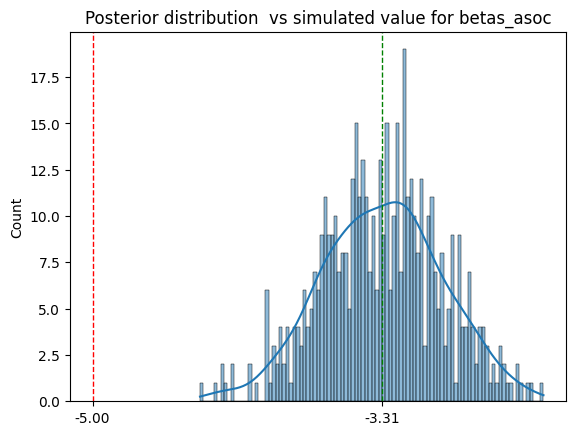

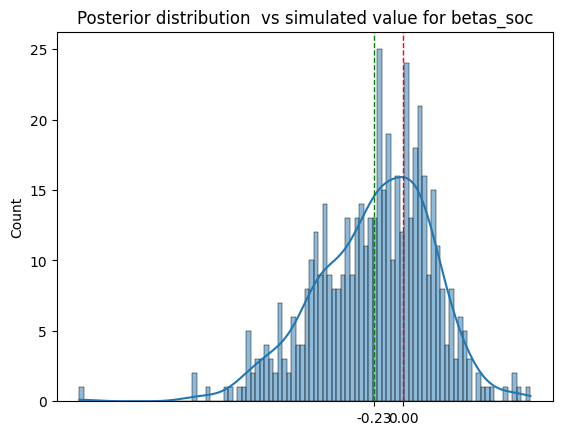

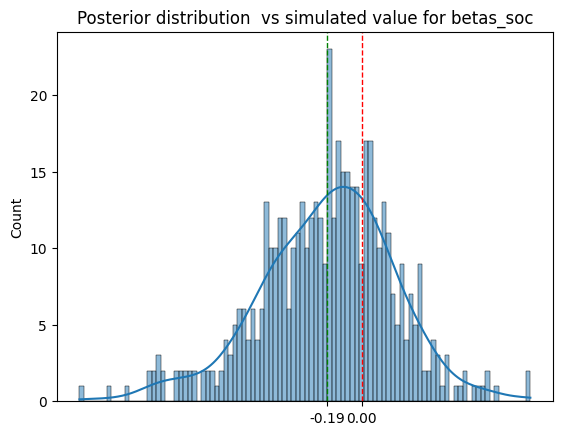

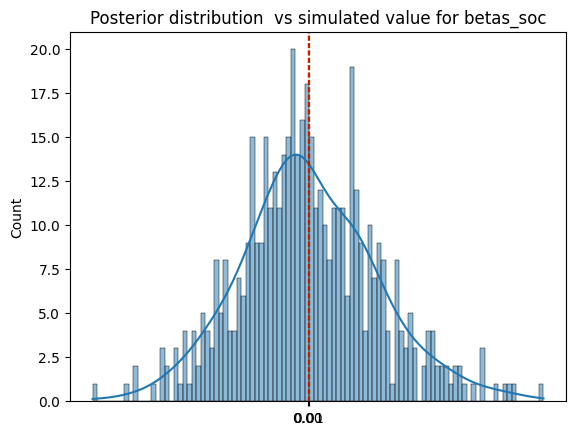

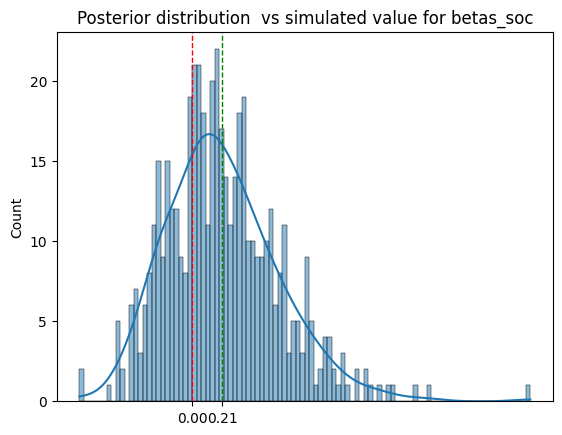

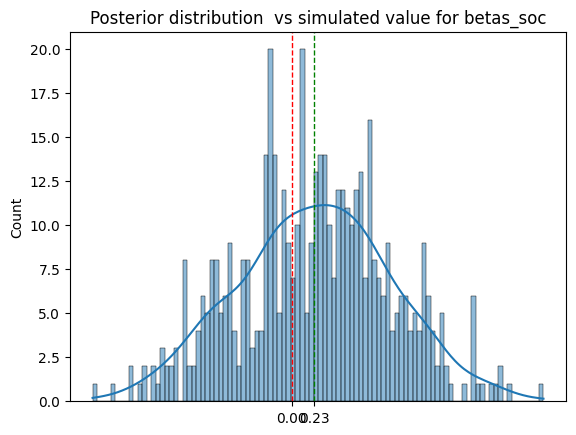

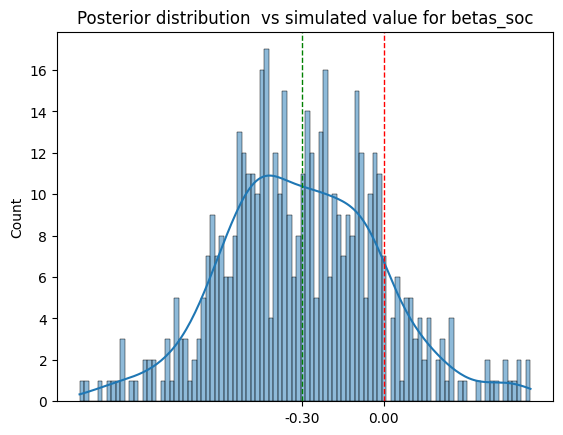

In [ ]:
params_kde(m, alpha_asocial=alpha_asocial, alpha_social= alpha_social)

## Testing R data

In [22]:
import json
with open('R_data.json', 'r') as file:
    data = json.load(file)
data.keys()

dict_keys(['net', 'status', 'covDF1', 'covDF2', 'covNF1', 'covNF2'])

In [59]:
rnet = jnp.array(data['net'])
print(rnet.shape)
rstatus = jnp.array(data['status'])
print(rstatus.shape)
covDF1 = jnp.array(data['covDF1'])
covDF1 = covDF1.at[jn]
print(covDF1.shape)
covDF2 = jnp.array(data['covDF2'])
print(covDF2.shape)
covDF = jnp.stack([covDF1, covDF2], axis = -1).reshape(100,100, 2)
print('covDF correct')
print(jnp.array_equal(covDF[:,:,0], covDF1))
covNF1 = jnp.array(data['covNF1'])
print(covNF1.shape)
covNF2 = jnp.array(data['covNF2'])
print(covNF2.shape)

rdf = pd.DataFrame(jnp.stack((covNF1, covNF2)).T)
rdf.head()

(100, 100)
(100, 200)
(100, 100)
(100, 100)
covDF correct
True
(100,)
(100,)


,0,1
0,-1.4612,0.0
1,1.5494,0.0
2,0.2454,0.0
3,-0.5237,0.0
4,-0.2347,0.0


In [111]:
nbda=NBDA(rnet, rstatus) 
nbda.import_covNF(rdf) 
nbda.import_covDF(covDF)
nbda.get_cov()

m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)



jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s, 15 steps of size 1.75e-01. acc. prob=0.94]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -5.85  0.31     -6.30      -5.30       0.02     0.01    255.08   
alpha_soc[0]  -8.17  0.70     -9.17      -7.00       0.05     0.04    182.96   
betas_asoc[0]  0.93  0.32      0.45       1.47       0.02     0.01    393.20   
betas_asoc[1] -0.68  0.72     -1.85       0.39       0.03     0.02    604.50   
betas_soc[0]  -1.81  0.28     -2.25      -1.39       0.02     0.01    253.63   
betas_soc[1]   1.47  0.37      0.83       1.98       0.02     0.02    309.58   
betas_soc[2]  -1.08  0.25     -1.51      -0.73       0.02     0.01    220.76   
betas_soc[3]   1.51  0.41      0.84       2.11       0.02     0.01    429.97   
betas_soc[4]  -0.26  0.88     -1.83       0.95       0.04     0.04    459.48   
betas_soc[5]   1.33  0.47      0.55       2.00       0.03     0.02    340.28   

               ess_tail  r_hat  
alpha_asoc[0]    297.75    NaN  
alpha_soc[0]     259.80    NaN  

In [125]:
covDF1

Array([[ 1.  ,  0.02,  0.23, ..., -0.02,  0.16,  0.12],
       [ 0.02,  1.  ,  0.09, ...,  0.13,  0.13,  0.1 ],
       [ 0.23,  0.09,  1.  , ...,  0.13,  0.07, -0.23],
       ...,
       [-0.02,  0.13,  0.13, ...,  1.  , -0.02, -0.02],
       [ 0.16,  0.13,  0.07, ..., -0.02,  1.  ,  0.15],
       [ 0.12,  0.1 , -0.23, ..., -0.02,  0.15,  1.  ]], dtype=float64)

In [124]:
bi.net.density(covDF1)

Array(1.01, dtype=float64)

alpha_asoc


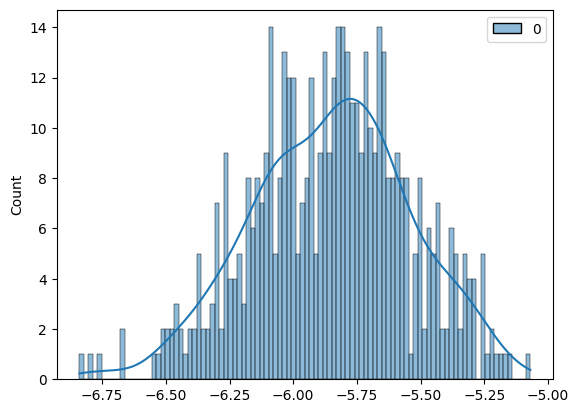

alpha_soc


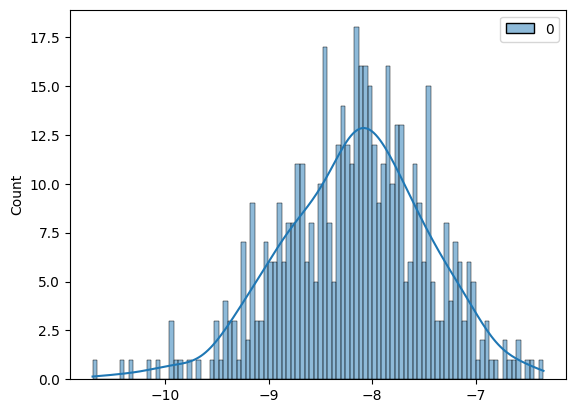

betas_asoc


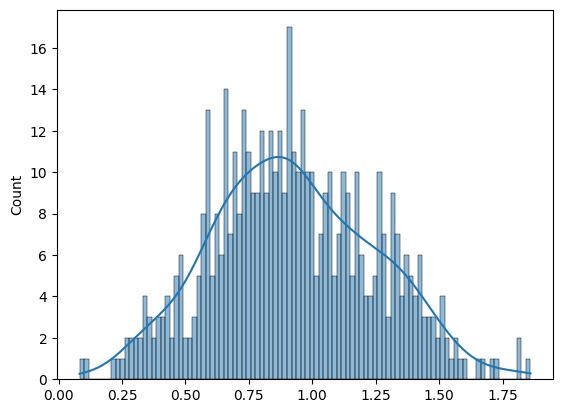

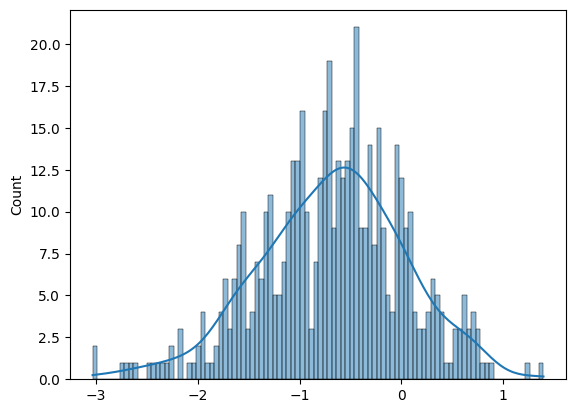

betas_soc


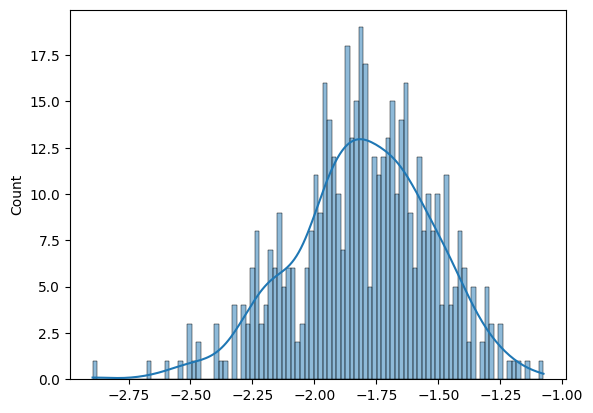

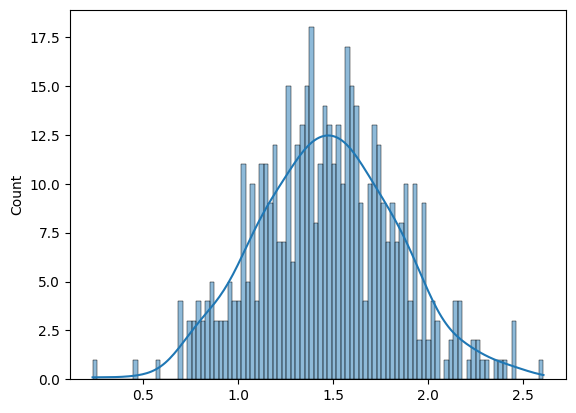

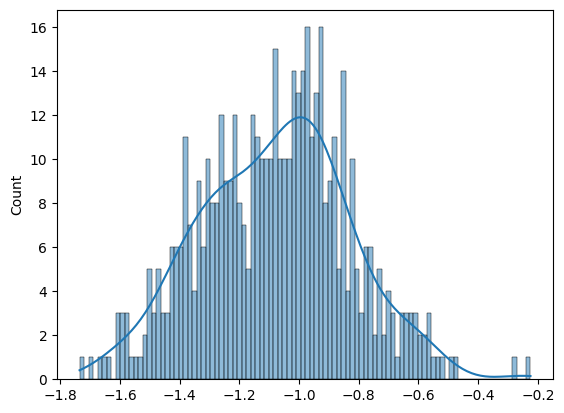

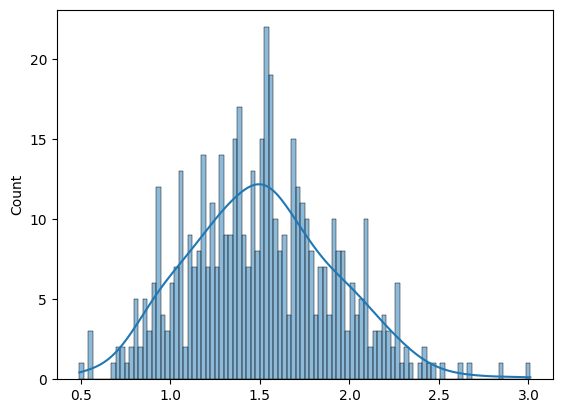

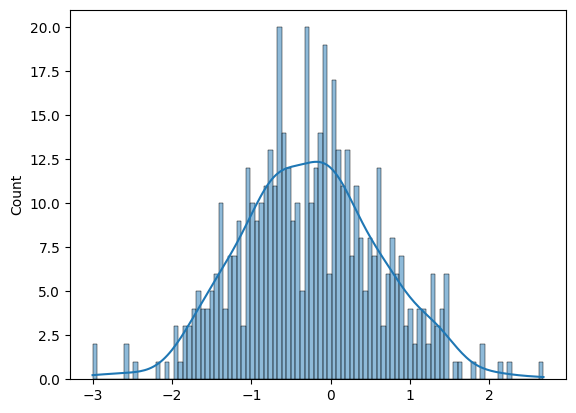

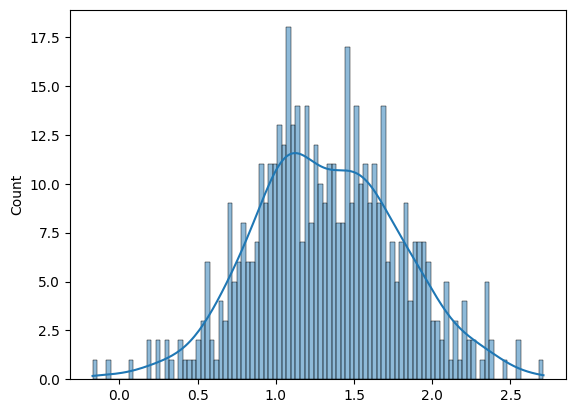

In [121]:
for k in m.posteriors.keys():
    print(k)
    if m.posteriors[k].shape[1] == 1:
        sns.histplot(m.posteriors[k], kde=True, bins = 100)
        plt.show()
    else:
        for i in range(m.posteriors[k].shape[1]):
            sns.histplot(m.posteriors[k][:,i], kde=True, bins = 100)
            plt.show()


## Multiple categories of behaviors

# [Constant elasticity of substitution](https://en.wikipedia.org/wiki/Constant_elasticity_of_substitution) to account for directionality and rate of learning based on network links

$Q = F \cdot \left( a \cdot K^\rho + (1 - a) \cdot L^\rho \right)^{\frac{\nu}{\rho}}$

where: 

- Q = Quantity of output

- F = Total Factor Productivity

- a = Share parameter

- K,L = Quantities of primary production factors (Capital and Labor)
 
- ρ = (σ − 1)/σ = Substitution parameter

- σ = 1/(1 - ρ) = [Elasticity of substitution](https://en.wikipedia.org/wiki/Elasticity_of_substitution)

- υ = degree of homogeneity of CES function. Where v = 1 (Constant return to scale),  υ  < 1 (Decreasing return to scale), υ > 1 (Increasing return to scale).


In [ ]:
@jax.jit
def ces(network, a, sigma, v):
    """
    Compute Constant elasticity of substitution (CES):
        Q = (a * K**rho + (1 - a) * L**rho)**(v/rho)
    
    Parameters:
      network (2D array): network where rows represent outgoing ties and coulmns incoming ties.
      a (float):  Share parameter
      v (float): = degree of homogeneity of CES function. Where v = 1 (Constant return to scale),  υ  < 1 (Decreasing return to scale), υ > 1 (Increasing return to scale).
      rho (float): Substitution parameter
    Returns:
      float: The computed output from the CES production function.
    """ 

    K = network
    L = network.T
    rho = (sigma - 1)/sigma
    return 2*(a * K**rho + (1 - a) * L**rho)**(v/rho) # ! *2 to recover 

net = create_random_network(5)
print("original network ---------")
print(net)

# if a, v and sigma are = 1 we should network
print("\n network---------")
print(ces(net, a = 1, v = 1, sigma = 1))

# if a = 0.5, and v and sigma are = 1 we should get network/2 + network.T/2
print("\n network/2 + network.T/2---------")
print(ces(net, a = 0.5, v = 1, sigma = 1))

# if a = 0, and v and sigma are = 1 we should get network.T
print("\n network.T---------")
print(ces(net, a = 0, v = 1, sigma = 1))

# Sigma is giving scaling incoming (as it reach 0) or outgoing (as it reach infinity), so it is a paramter that give information on directionality importance for soicla transmision
print("\n binary network---------")
print(ces(net, a = 1, v = 1, sigma =0.00001)) 

# V is link weigths scale parameter as it increase it increase effect of links weigths and as it reach zero it concider only presence or abscence
# !How to get network + network.T ?


original network ---------
[[0 0 0 0 0]
 [0 0 0 0 2]
 [0 2 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 0]]

 network---------
[[0 0 0 0 0]
 [0 0 0 0 2]
 [0 2 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 0]]

 network/2 + network.T/2---------
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0.]]

 network.T---------
[[0 0 0 0 0]
 [0 0 2 0 0]
 [0 0 0 0 2]
 [0 0 0 0 0]
 [0 2 0 0 0]]

 binary network---------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


# Joint model of SRM+BLOCK with NBDA

# Time varying coefficients

In [ ]:
def coefficients(V, T,
                mu_mu =  0,
                mu_sigma = 1,
                sigma_mu = 1,
                sample = False,
                name = 'betas_soc'):
    """
    Generates time-varying coefficients using hierarchical normal distributions.

    Args:
        V (int): Number of coefficients.
        T (int): Number of time points.
        mu_mu (float, optional): Mean of the Mu_betas distribution. Defaults to 0.0.
        mu_sigma (float, optional): Mean of the Sigma_betas distribution. Defaults to 1.
        sigma_mu (float, optional): Standard deviation of the Mu_betas distribution. Defaults to 1.
        name (str, optional): Name for identification. Defaults to 'betas_soc'.

    Returns:
        Tensor: A tensor of shape (T, V) representing time-varying coefficients.

    Distribution Details:
        - Mu_betas: Normal distribution with mean=mu_mu and std=sigma_mu
        - Sigma_betas: Normal distribution with mean=mu_sigma and std=sigma_sigma
        - betas: Normal distribution with mean=Mu_betas and std=Sigma_betas
    """

    Mu_betas = bi.dist.normal(mu_mu, mu_sigma, shape = (V,), sample=sample, name='Mu_'+name)
    Sigma_betas = bi.dist.exponential(sigma_mu, shape = (V,), sample=sample, name='Sigma_'+name)
    betas = bi.dist.normal(Mu_betas, Sigma_betas, shape = (T,), sample=sample, name='betas_'+name).reshape(T, V)
    return betas

coefficients(4, 10, sample = True) # 4 variables 10 time points

## Model

In [ ]:
def model(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = coefficients(1, T, mu_mu =  0, mu_sigma = 5, sigma_mu = 1, name = 'alpha_soc')
    # Priors for asocial effect covariates
    asoc = coefficients(1,  T, mu_mu =  0, mu_sigma = 5, sigma_mu = 1, name = 'alpha_asoc')
    # Asocial learning for time t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc[0, :].reshape(1,), axes=(-1, 0))
    theta = bi.link.inv_logit(R_asocial)
    lk = lk.at[:,0].set(theta)



    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc[t, :].reshape(1,), axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))
        #status_network = jnp.tensordot(network[:,:,t,0], status[:,t-1], axes=(-1, 0))
        #attention_weigthed_network = phi[0,:]*status_network
        #social_influence_weight = inv_logit2(attention_weigthed_network)

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc[t, :].reshape(1,), axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)
        
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

## Running a single simulation 
No covariates, only asocial and social intercept.

In [ ]:
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1])
alpha_asocial =jnp.array([-5])
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

nbda=NBDA(covariates_data['network'], status) 
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

In [11]:
summary

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Mu_alpha_asoc[0],-5.12,0.21,-5.42,-4.77,0.03,0.02,70.98,219.90,NaN
Mu_alpha_soc[0],1.60,0.85,0.51,2.92,0.31,0.23,11.71,22.67,NaN
Sigma_alpha_asoc[0],0.49,0.26,0.13,0.84,0.07,0.05,14.31,75.67,NaN
Sigma_alpha_soc[0],1.24,0.80,0.22,2.31,0.48,0.39,2.38,24.79,NaN
betas_alpha_asoc[0],-5.39,0.58,-6.21,-4.55,0.06,0.05,107.25,341.10,NaN
...,...,...,...,...,...,...,...,...,...
betas_alpha_soc[95],1.60,1.68,-0.73,4.66,0.23,0.25,69.99,83.85,NaN
betas_alpha_soc[96],1.50,1.63,-0.99,4.11,0.16,0.27,115.41,42.62,NaN
betas_alpha_soc[97],1.56,1.62,-0.52,4.21,0.30,0.27,70.54,38.28,NaN
betas_alpha_soc[98],1.56,1.78,-0.69,4.31,0.19,0.24,94.82,47.25,NaN


In [12]:
temporalCoeff = m 

In [13]:
for k in m.posteriors.keys():
    print(k)
    print(m.posteriors[k].mean())

Mu_alpha_asoc
-5.121081461123768
Mu_alpha_soc
1.5972383130353356
Sigma_alpha_asoc
0.49218145223983767
Sigma_alpha_soc
1.2443165282206567
betas_alpha_asoc
-5.120433623681624
betas_alpha_soc
1.592933659770799


In [ ]:
tmp = dict(betas_alpha_soc = m.posteriors['betas_alpha_soc'], betas_alpha_asoc = m.posteriors['betas_alpha_asoc'])
plot_distributions(tmp,  dict(betas_alpha_soc=alpha_asocial, betas_alpha_asoc=alpha_social), by_param=False)

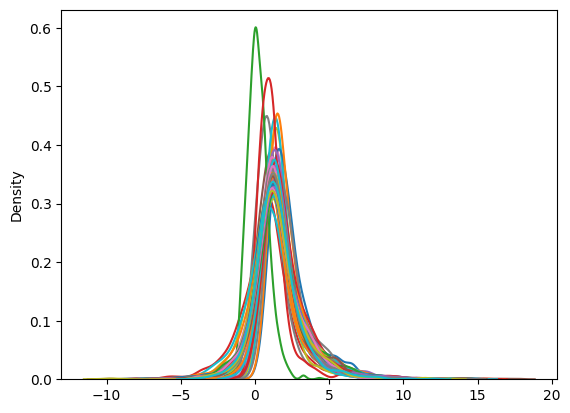

In [24]:
for i in range(m.posteriors['betas_alpha_soc'].shape[1]):
    sns.kdeplot(m.posteriors['betas_alpha_soc'][:,i])


## With multiple processes
